# Cluster Activities on Baseline Thresholds for Acceleration and Angular Velocity

Each trial of stimulated activity is presented as a time series of sensor data collected over a 10, 30, or 60 second interval. As a prelimary method to process this data, the maximum value from every trial will be taken as a potential threshold to represent that particular activity. By clustering on these values, we hope to identify potential threshold acceleration and angular velocity values that discriminates a fall from an ADL.

In future analyses, different processing methods should be attempted to preserve more data from the experimental trials as this approach discards all of the sensor measurements besides the max value.

In [270]:
import datetime
import pandas as pd
import numpy as np
from statistics import mean
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

In [217]:
# Load Data
rawData = pd.read_csv('https://raw.githubusercontent.com/mjwolfe91/MSDS_Capstone_JC_AN_MW/master/Data/HAR_FALL-UP_CompleteDataSet.csv')

# Extract Wrist Sensor Data (Angular/Accelerometer) from each trial for every subject
# 17 subjects * 11 activities (ADL/Falls) * 3 trials = 561 trials
# Sensors set at sampling rate of ~18.4 Hz (18-20 Hz)
raw_WristSensor = rawData[['TimeStamps','WristAccelerometer', 'Unnamed: 30', 'Unnamed: 31', 'WristAngularVelocity', 'Unnamed: 33', 'Unnamed: 34','Subject', 'Activity', 'Trial']]
# Rename Columns
raw_WristSensor.rename(columns = {'TimeStamps':'TimeStamp', 'WristAccelerometer': 'Accelerometer (x)', 'Unnamed: 30':'Accelerometer (y)','Unnamed: 31':'Accelerometer (z)', 'WristAngularVelocity': 'Angular Velocity (x)', 'Unnamed: 33':'Angular Velocity (y)','Unnamed: 34':'Angular Velocity (z)'}, inplace = True)
# Change data types 
raw_WristSensor.TimeStamp = pd.to_datetime(raw_WristSensor.TimeStamp)
for col in ['Accelerometer (x)','Accelerometer (y)','Accelerometer (z)','Angular Velocity (x)','Angular Velocity (y)','Angular Velocity (z)']:
    raw_WristSensor[col] = pd.to_numeric(raw_WristSensor[1:][col])
for col in ['Subject', 'Activity', 'Trial']:
    raw_WristSensor[col] = raw_WristSensor[col].astype('category')
#raw_WristSensor.dtypes

# Magntiude of Accelerometer and Gyroscope sensors
a_mag = np.sqrt(raw_WristSensor['Accelerometer (x)']**2 + raw_WristSensor['Accelerometer (y)']**2 + raw_WristSensor['Accelerometer (z)']**2)
w_mag = np.sqrt(raw_WristSensor['Angular Velocity (x)']**2 + raw_WristSensor['Angular Velocity (y)']**2 + raw_WristSensor['Angular Velocity (z)']**2)
raw_WristSensor.insert(10, 'Acceleration Magntiude', a_mag)
raw_WristSensor.insert(11, 'Angular Velocity Magntiude', w_mag)

In [223]:
raw_WristSensor.dtypes

TimeStamp                     datetime64[ns]
Accelerometer (x)                    float64
Accelerometer (y)                    float64
Accelerometer (z)                    float64
Angular Velocity (x)                 float64
Angular Velocity (y)                 float64
Angular Velocity (z)                 float64
Subject                             category
Activity                            category
Trial                               category
Acceleration Magntiude               float64
Angular Velocity Magntiude           float64
dtype: object

In [218]:
def sortTrial(dict_,row_):
    if raw_WristSensor.Trial[i] == 1:
        dict_['T1'].append(row_)
    elif raw_WristSensor.Trial[i] == 2:
        dict_['T2'].append(row_)
    elif raw_WristSensor.Trial[i] == 3:
        dict_['T3'].append(row_)

def sortActivityTrial(dict_,row_):
    if raw_WristSensor.Activity[i] == 1:
        sortTrial(dict_['A1'],row_)
        #dict_['A1'].append(row_)
    elif raw_WristSensor.Activity[i] == 2:
        sortTrial(dict_['A2'],row_)
        #dict_['A2'].append(row_)
    elif raw_WristSensor.Activity[i] == 3:
        sortTrial(dict_['A3'],row_)
        #dict_['A3'].append(row_)
    elif raw_WristSensor.Activity[i] == 4:
        sortTrial(dict_['A4'],row_)
        #dict_['A4'].append(row_)
    elif raw_WristSensor.Activity[i] == 5:
        sortTrial(dict_['A5'],row_)
        #dict_['A5'].append(row_)
    elif raw_WristSensor.Activity[i] == 6:
        sortTrial(dict_['A6'],row_)
        #dict_['A6'].append(row_)
    elif raw_WristSensor.Activity[i] == 7:
        sortTrial(dict_['A7'],row_)
        #dict_['A7'].append(row_)
    elif raw_WristSensor.Activity[i] == 8:
        sortTrial(dict_['A8'],row_)
        #dict_['A8'].append(row_)
    elif raw_WristSensor.Activity[i] == 9:
        sortTrial(dict_['A9'],row_)
        #dict_['A9'].append(row_)
    elif raw_WristSensor.Activity[i] == 10:
        sortTrial(dict_['A10'],row_)
        #dict_['A10'].append(row_)
    elif raw_WristSensor.Activity[i] == 11:
        sortTrial(dict_['A11'],row_)
        #dict_['A11'].append(row_)

In [219]:
# Aggregate Wrist Sensor data by Subjects
WristS_Subjects = {}

for s in np.unique(raw_WristSensor.Subject[1:]):
    WristS_Subjects["S{0}".format(int(s))] = {"A1":{"T1":[],"T2":[],"T3":[]},"A2":{"T1":[],"T2":[],"T3":[]},"A3":{"T1":[],"T2":[],"T3":[]},"A4":{"T1":[],"T2":[],"T3":[]},"A5":{"T1":[],"T2":[],"T3":[]}, "A6":{"T1":[],"T2":[],"T3":[]},
                                              "A7":{"T1":[],"T2":[],"T3":[]},"A8":{"T1":[],"T2":[],"T3":[]},"A9":{"T1":[],"T2":[],"T3":[]},"A10":{"T1":[],"T2":[],"T3":[]},"A11":{"T1":[],"T2":[],"T3":[]}}


for i, row in raw_WristSensor[1:].iterrows():
    if raw_WristSensor.Subject[i] == 1:
        sortActivityTrial(WristS_Subjects['S1'],row)
    elif raw_WristSensor.Subject[i] == 2:
        sortActivityTrial(WristS_Subjects['S2'],row)
    elif raw_WristSensor.Subject[i] == 3:
        sortActivityTrial(WristS_Subjects['S3'],row)
    elif raw_WristSensor.Subject[i] == 4:
        sortActivityTrial(WristS_Subjects['S4'],row)
    elif raw_WristSensor.Subject[i] == 5:
        sortActivityTrial(WristS_Subjects['S5'],row)
    elif raw_WristSensor.Subject[i] == 6:
        sortActivityTrial(WristS_Subjects['S6'],row)
    elif raw_WristSensor.Subject[i] == 7:
        sortActivityTrial(WristS_Subjects['S7'],row)
    elif raw_WristSensor.Subject[i] == 8:
        sortActivityTrial(WristS_Subjects['S8'],row)
    elif raw_WristSensor.Subject[i] == 9:
        sortActivityTrial(WristS_Subjects['S9'],row)
    elif raw_WristSensor.Subject[i] == 10:
        sortActivityTrial(WristS_Subjects['S10'],row)
    elif raw_WristSensor.Subject[i] == 11:
        sortActivityTrial(WristS_Subjects['S11'],row)
    elif raw_WristSensor.Subject[i] == 12:
        sortActivityTrial(WristS_Subjects['S12'],row)
    elif raw_WristSensor.Subject[i] == 13:
        sortActivityTrial(WristS_Subjects['S13'],row)
    elif raw_WristSensor.Subject[i] == 14:
        sortActivityTrial(WristS_Subjects['S14'],row)
    elif raw_WristSensor.Subject[i] == 15:
        sortActivityTrial(WristS_Subjects['S15'],row)
    elif raw_WristSensor.Subject[i] == 16:
        sortActivityTrial(WristS_Subjects['S16'],row)
    elif raw_WristSensor.Subject[i] == 17:
        sortActivityTrial(WristS_Subjects['S17'],row)

# Change lists to numpy array
# Column idx of numpy array [0:Timestamp, 1: Accelerometer (x), 2: Accelerometer (y), 3: Accelerometer (z),
#                                         4: Angular Velocity (x), 5 Angular Velocity (y), 6: Angular Velocity (z)
#                                         7: Subject, 8: Activity, 9: Trial, 10: Acceleration Magntiude, 11: Angular Velcoity Magntiude]
for subject in WristS_Subjects.keys():
    for activity in WristS_Subjects[subject].keys():
        for trial in WristS_Subjects[subject][activity].keys():
            WristS_Subjects[subject][activity][trial] = np.array(WristS_Subjects[subject][activity][trial])
            WristS_Subjects[subject][activity][trial] = np.reshape(WristS_Subjects[subject][activity][trial], (-1,12))

In [230]:
cluster_thresholds = pd.DataFrame(columns = ["Subject","Activity","Trial","Max Acceleration Magnitude","Max Angular Velocity Magnitude"])
# Column idx of dataframe [0:Subject, 1: Activity, 2: Trial, 3: Max Acceleration Magnitude, 4: Max Angular Velocity Magnitude]

for subject in WristS_Subjects.keys():
    for activity in WristS_Subjects[subject].keys():
        for trial in WristS_Subjects[subject][activity].keys():
            # Subject 8 is missing data for Trials 2/3 of Activity 11
            if (subject == "S8") & (activity == "A11") & (trial in ["T2","T3"]):
                continue
            else:
                maxA = max(WristS_Subjects[subject][activity][trial][:,10])
                maxW = max(WristS_Subjects[subject][activity][trial][:,11])
                s = mean(WristS_Subjects[subject][activity][trial][:,7])
                a = mean(WristS_Subjects[subject][activity][trial][:,8])
                t = mean(WristS_Subjects[subject][activity][trial][:,9])
                cluster_thresholds = cluster_thresholds.append({"Subject":s, "Activity":a, "Trial":t, "Max Acceleration Magnitude":maxA, "Max Angular Velocity Magnitude":maxW}, ignore_index=True)

In [233]:
cluster_thresholds.dtypes

Subject                           float64
Activity                          float64
Trial                             float64
Max Acceleration Magnitude        float64
Max Angular Velocity Magnitude    float64
dtype: object

In [232]:
cluster_thresholds[cluster_thresholds['Activity']<6]

,Subject,Activity,Trial,Max Acceleration Magnitude,Max Angular Velocity Magnitude
0,1.0,1.0,1.0,4.998200,557.309722
1,1.0,1.0,2.0,4.483198,334.218375
2,1.0,1.0,3.0,3.323694,363.059450
3,1.0,2.0,1.0,2.722826,721.363913
4,1.0,2.0,2.0,3.129536,558.034051
...,...,...,...,...,...
536,17.0,4.0,2.0,4.716520,421.583399
537,17.0,4.0,3.0,4.016599,476.319064
538,17.0,5.0,1.0,3.106302,444.554709
539,17.0,5.0,2.0,3.046350,473.610628


In [241]:
cluster_thresholds["Max Acceleration Magnitude"]

0      4.998200
1      4.483198
2      3.323694
3      2.722826
4      3.129536
         ...   
554    4.084658
555    4.221304
556    1.886194
557    1.071376
558    1.975824
Name: Max Acceleration Magnitude, Length: 559, dtype: float64

In [250]:
len(np.unique(cluster_thresholds['Activity']))

11

In [267]:
cluster_thresholds["Subject"] = cluster_thresholds["Subject"].astype('category')
cluster_thresholds["Activity"] = cluster_thresholds["Activity"].astype('category')
cluster_thresholds["Trial"] = cluster_thresholds["Trial"].astype('category')
cluster_thresholds.dtypes

Subject                           category
Activity                          category
Trial                             category
Max Acceleration Magnitude         float64
Max Angular Velocity Magnitude     float64
dtype: object

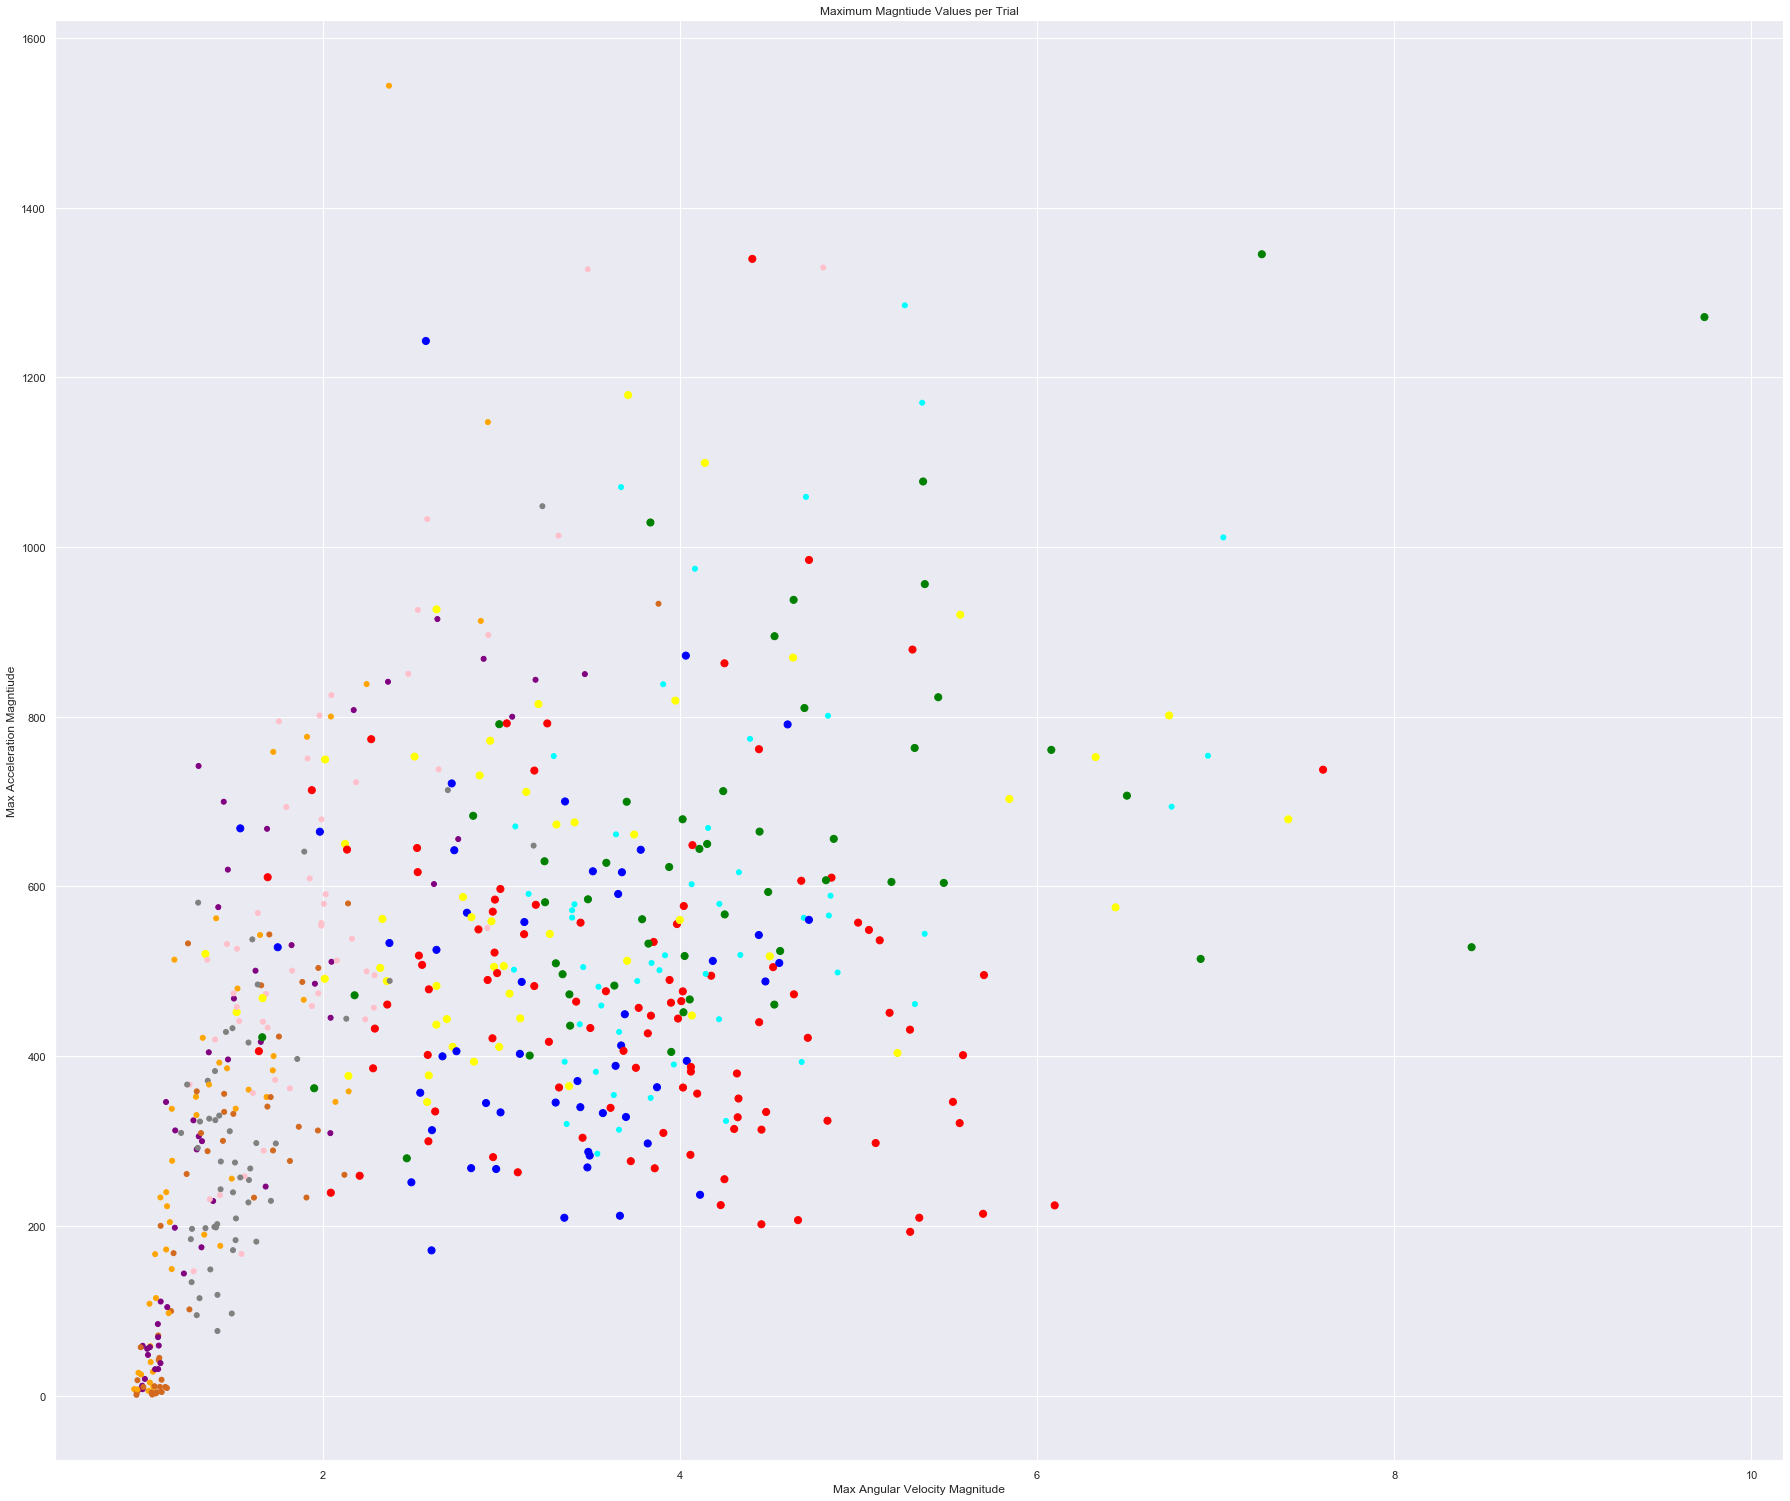

In [282]:
%matplotlib inline
fig=plt.figure(figsize = (24,20))
ax=fig.add_axes([0,0,1,1])
colormap = {1:'red',2:'blue',3:'green',4:'red',5:'yellow',6:'pink',7:'purple',8:'orange',9:'grey',10:'cyan',11:'chocolate'}
sizemap = {1:50,2:50,3:50,4:50,5:50,6:25,7:25,8:25,9:25,10:25,11:25}
markermap = {1:'x',2:'x',3:'x',4:'x',5:'x',6:'.',7:'.',8:'.',9:'.',10:'.',11:'.'}
ax.scatter(y=cluster_thresholds["Max Angular Velocity Magnitude"], x=cluster_thresholds["Max Acceleration Magnitude"], c=cluster_thresholds['Activity'].apply(lambda x:colormap[x]), 
s=cluster_thresholds['Activity'].apply(lambda x:sizemap[x]))
ax.set_title("Maximum Magntiude Values per Trial")
ax.set_xlabel("Max Angular Velocity Magnitude")
ax.set_ylabel("Max Acceleration Magntiude")
plt.show()

In [274]:
cluster_thresholds.iloc[:,3:5]

,Max Acceleration Magnitude,Max Angular Velocity Magnitude
0,4.998200,557.309722
1,4.483198,334.218375
2,3.323694,363.059450
3,2.722826,721.363913
4,3.129536,558.034051
...,...,...
554,4.084658,974.366832
555,4.221304,579.381561
556,1.886194,487.409934
557,1.071376,3.942320


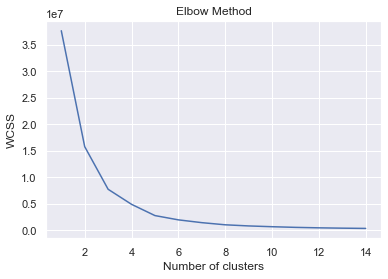

In [275]:
X = cluster_thresholds.iloc[:,3:5]
wcss = []
for i in range(1, 15):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 15), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [277]:
X.iloc[:,1]

0      557.309722
1      334.218375
2      363.059450
3      721.363913
4      558.034051
          ...    
554    974.366832
555    579.381561
556    487.409934
557      3.942320
558    503.931906
Name: Max Angular Velocity Magnitude, Length: 559, dtype: float64

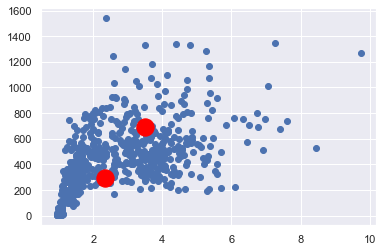

In [288]:
kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(X)
plt.scatter(x=X.iloc[:,0], y=X.iloc[:,1])
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
plt.show()

In [289]:
kmeans.cluster_centers_
# Fall cluster: 3.50 acceleration, 694.076 angular velocity
# ADL cluster: 2.33 acceleration, 292.689 angular velocity

array([[  3.50222037, 694.07635889],
       [  2.33117836, 292.68937724]])

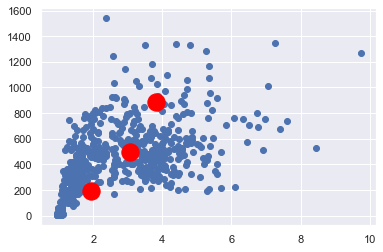

In [287]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(X)
plt.scatter(x=X.iloc[:,0], y=X.iloc[:,1])
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
plt.show()

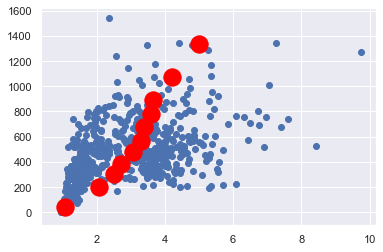

In [284]:
kmeans = KMeans(n_clusters=11, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(X)
plt.scatter(x=X.iloc[:,0], y=X.iloc[:,1])
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
plt.show()

[Text(0, 0.5, 'Max Acceleration Magntiude'),
 Text(0.5, 0, 'Max Angular Velocity Magnitude')]

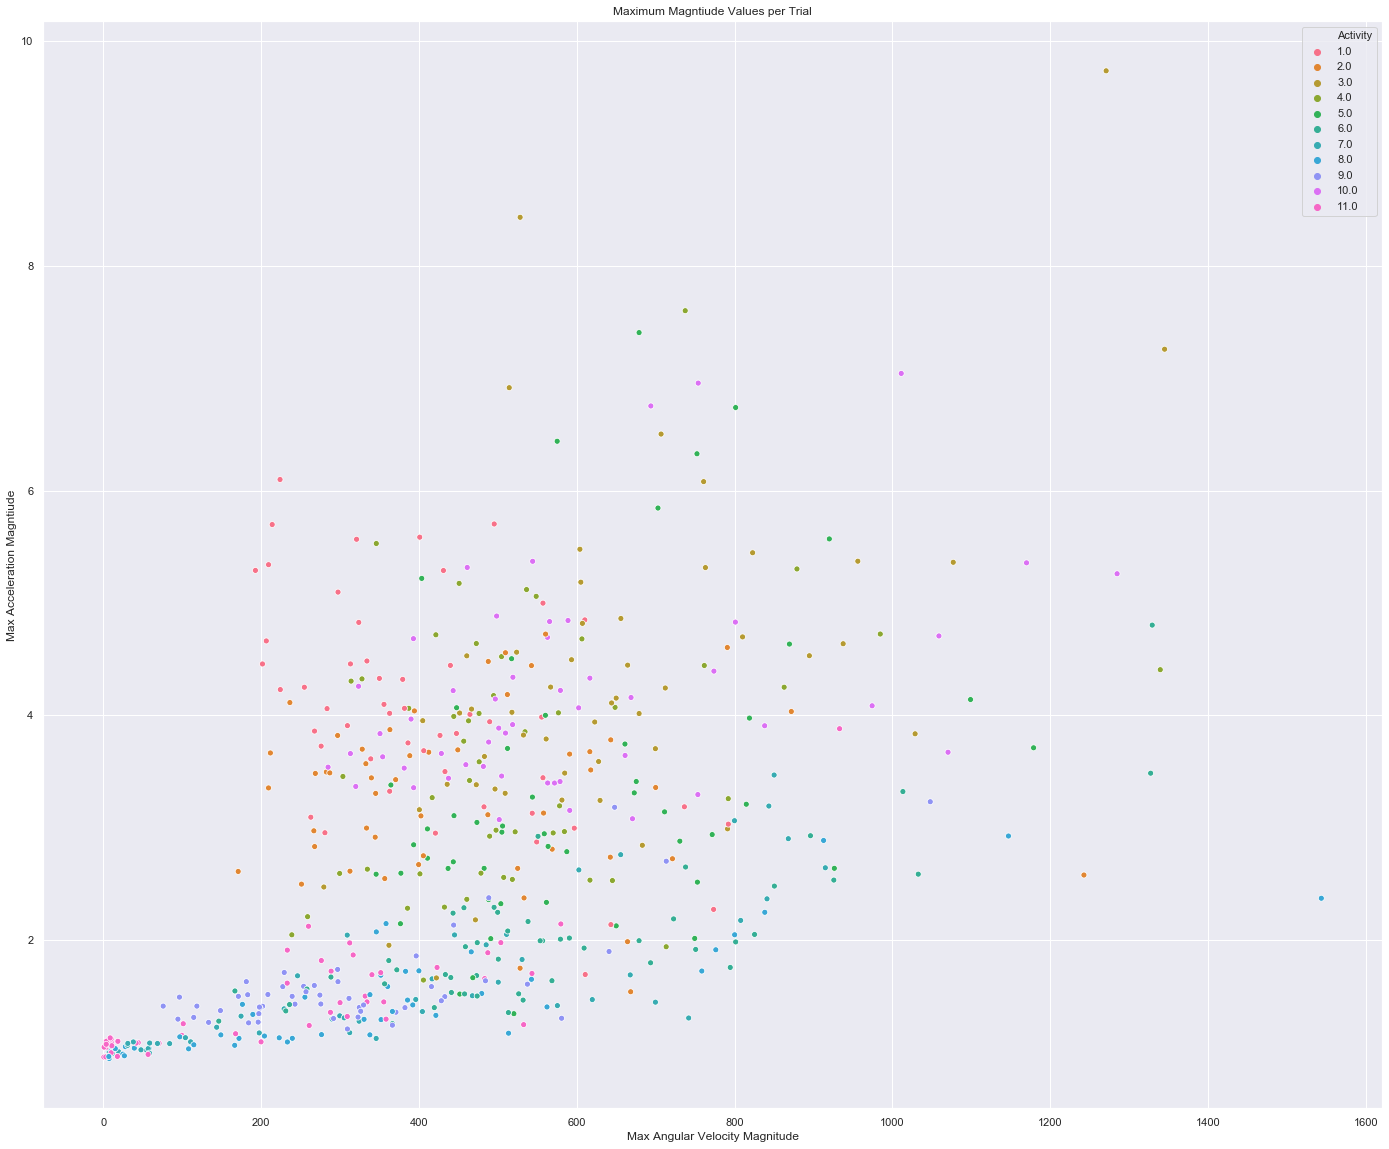

In [240]:
sns.set(rc={'figure.figsize':(24,20)})
clusters = sns.scatterplot(x="Max Angular Velocity Magnitude", y="Max Acceleration Magnitude", hue=cluster_thresholds["Activity"].astype('category'), data=cluster_thresholds)
clusters.set_title("Maximum Magntiude Values per Trial")
clusters.set(xlabel="Max Angular Velocity Magnitude", ylabel="Max Acceleration Magntiude")

In [216]:
cluster_thresholds["Activity"]

0       1.0
1       1.0
2       1.0
3       2.0
4       2.0
       ... 
554    10.0
555    10.0
556    11.0
557    11.0
558    11.0
Name: Activity, Length: 559, dtype: category
Categories (11, float64): [1.0, 2.0, 3.0, 4.0, ..., 8.0, 9.0, 10.0, 11.0]

In [119]:
len(WristS_Subjects['S1'])

11

In [81]:
len(raw_WristSensor[raw_WristSensor["Subject"]==3.0])

17845

In [143]:
len(raw_WristSensor.loc[(raw_WristSensor["Subject"]==17.0) & (raw_WristSensor["Activity"]==9.0) & (raw_WristSensor["Trial"]==1.0)])

182

In [120]:
i=0
for subject in WristS_Subjects.keys():
    for activity in WristS_Subjects[subject].keys():
        for trial in WristS_Subjects[subject][activity].keys():
            print(len(WristS_Subjects[subject][activity][trial]))
            i+=1

195
193
194
157
195
194
192
191
190
189
191
193
189
182
187
1133
1124
1115
1121
1101
1084
1079
1088
1054
181
177
174
530
525
499
1062
1039
1014
171
171
175
174
168
175
177
173
177
180
167
168
168
140
147
1033
1062
1094
1063
1031
1030
1056
1041
1031
162
158
166
459
470
471
982
947
936
188
187
186
187
177
185
191
181
184
191
189
189
186
179
183
1124
1105
1064
1100
1067
1089
1088
1078
1071
176
175
169
526
517
536
1069
1070
1038
183
186
185
183
189
191
181
183
186
187
193
191
182
182
180
1089
1092
1089
1086
1066
1080
1078
1071
1057
178
179
180
533
529
536
1058
1064
1068
185
186
183
192
188
189
192
192
191
193
193
194
194
189
192
1096
1117
1112
1075
1126
1126
1093
1090
1109
186
193
187
566
556
563
1092
1088
1065
150
149
150
149
150
149
150
150
150
150
150
150
150
149
150
899
899
898
875
870
875
866
858
863
146
141
146
440
434
441
879
888
893
184
191
189
188
183
186
191
184
182
190
187
188
187
184
188
1121
1129
1116
1083
1077
1105
1088
1050
1063
189
185
192
573
562
566
1120
1047
1052
187
186

In [121]:
i

561

In [122]:
17*11*3

561

In [23]:
max(WristS_Subjects['S1'][:,10])

5.174296570549469

In [254]:
from sklearn.datasets import load_iris
iris = load_iris()
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')